<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mise-en-place-de-l'environnement" data-toc-modified-id="Mise-en-place-de-l'environnement-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mise en place de l'environnement</a></span><ul class="toc-item"><li><span><a href="#Test-de-l'Environnement" data-toc-modified-id="Test-de-l'Environnement-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test de l'Environnement</a></span></li></ul></li><li><span><a href="#Implémentation-de-l'Algorithme-Deep-Deterministic-Policy-Gradient-(DDPG)" data-toc-modified-id="Implémentation-de-l'Algorithme-Deep-Deterministic-Policy-Gradient-(DDPG)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implémentation de l'Algorithme Deep Deterministic Policy Gradient (DDPG)</a></span><ul class="toc-item"><li><span><a href="#Création-de-l'Acteur" data-toc-modified-id="Création-de-l'Acteur-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Création de l'Acteur</a></span></li><li><span><a href="#Création-du-Critique" data-toc-modified-id="Création-du-Critique-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Création du Critique</a></span></li><li><span><a href="#Création-du-Générateur-de-Bruit" data-toc-modified-id="Création-du-Générateur-de-Bruit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Création du Générateur de Bruit</a></span></li><li><span><a href="#Gestion-de-l'Experience-Replay" data-toc-modified-id="Gestion-de-l'Experience-Replay-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Gestion de l'Experience Replay</a></span></li><li><span><a href="#Mise-à-jour-des-réseaux-cibles" data-toc-modified-id="Mise-à-jour-des-réseaux-cibles-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Mise à jour des réseaux cibles</a></span></li><li><span><a href="#Apprentissage" data-toc-modified-id="Apprentissage-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Apprentissage</a></span></li><li><span><a href="#Diagnostique" data-toc-modified-id="Diagnostique-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Diagnostique</a></span></li><li><span><a href="#Réglage-des-paramètres-d'apprentissage" data-toc-modified-id="Réglage-des-paramètres-d'apprentissage-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Réglage des paramètres d'apprentissage</a></span></li></ul></li></ul></div>

Les modèles (physiques ou corrélatifs) des pneumatiques jouent un rôle essentiel dans la mise au points de scénarios de conception ainsi que dans l'évaluation des performances des nouvelles gammes ou de gammes existantes. Ainsi, le modèle de rigidité de dérive vu dans le TP portant sur l'Optimisation Bayesienne, peut être exploité à travers des chaines de simulation pour juger de la qualité de pneumatiques en terme de critère de comportement, d'adhérence, d'endurance ou encore de temps au tour. C'est à cette performance que nous allons nous intéresser ici.

Plus précisément, l'exercice consiste à mettre en place un environnement de simulation basé sur de l'apprentissage par renforcement qui a pour objectif de trouver les controles optimaux à appliquer à un véhicule pour que ce dernier puisse parcourir un circuit circulaire avec la vitesse la plus élevée possible.

## Mise en place de l'environnement

En l'occurence, les états que l'on va considérer pour notre environnement sont:
- $x$: position du véhicule selon la direction $\vec{X}$
- $y$: position du véhicule selon la direction $\vec{Y}$
- $\psi$: l'angle de lacet du véhicule
- $\dot{x}$: vitesse du véhicule selon la direction $\vec{X}$
- $\dot{y}$: vitesse du véhicule selon la direction $\vec{Y}$
- $\dot{\psi}$: vitesse de lacet du véhicule

Les actions qui seront utilisées sont:
- $v$: la vitesse
- $\alpha$: l'angle de braquage

L'environnement que l'on va exploiter s'appuie sur le package Gym de la société OpenAI (https://gym.openai.com/). Un tel environnement s'appuie sur l'utilisation d'objets héritant de la classe *gym.Env* et comportant les méthodes suivantes:
- **__init__**: constructeur définissant les expaces d'actions (*action_space*) et d'observations (*observation_space*)
- **reset**: méthode permettant de réinitialiser les états
- **step**: fonction qui prend en entrée les valeurs des actions et renvoie les nouveaux états de l'environnement, le reward ainsi qu'un booléen indiquant s'il est nécessaire de réinitialiser les états 
- **render**: méthode qui affiche l'état de l'environnement et différentes informations le concernant 

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

%matplotlib qt
%matplotlib inline

from gym_gmmcar.envs.circle_env import CircleEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Notre objectif étant de rester sur le cirucuit tout en allant le plus vite possible, quel(-s) reward(-s) peut-on envisager? Implémenter l'un d'entre eux en complétant la méthode *get_reward* de la classe *OttEnv* ci-dessous:

In [3]:
class OttEnv(CircleEnv):
    """
    Environnement de simulation pour une voiture de course suivant une trajectoire circulaire aussi vite que possible
    """

    def __init__(
            self,
            target_velocity=1.0,
            radius=1.0,
            dt=0.035,
            model_type='BrushTireModel',
            robot_type='RCCar',
            mu_s=1.37,
            mu_k=1.96,
            eps=0.05
    ):

        super().__init__(
            target_velocity=target_velocity,
            radius=radius,
            dt=dt,
            model_type=model_type,
            robot_type=robot_type,
            mu_s=mu_s,
            mu_k=mu_k
        )

        self.eps = eps


    def get_reward(self, state, action):
        """
        Définition de la fonction de Reward
        """
        r = self.radius
        x, y, _, x_dot, y_dot, _ = state
        vitesse = np.sqrt(x_dot**2 + y_dot**2)
        distance = np.sqrt(x**2 + y**2) - r

        # Le reward est la vitesse actuelle (composante positive) moins une pénalité de sortie de piste
        reward = vitesse 
        
        # Pénalité : si on est loin de la trajectoire idéale, pénalité quadratique
        # On utilise une fonction lisse pour la pénalité: -10 * (distance / r)^2 si |distance| > eps
        if np.abs(distance) > self.eps:
             reward -= 5.0 * (distance / r)**2 

        # Grande pénalité si l'état est "done" (sortie de piste complète/crash)
        done = self._get_done(state)
        if done:
             reward -= 100.0 # Pénalité sévère en cas de fin d'épisode

        info = {}
        info['dist'] = distance
        info['vel'] = vitesse
        return reward, info
    # --- AJOUT DE LA MÉTHODE MANQUANTE ---
    def step(self, action):
        next_state, reward, done, info = super().step(action)
        observation = self.state_to_observation(next_state)
        return observation, reward, done, info

    def _get_done(self, state):
        """
        Détermine si l'épisode doit s'arrêter (sortie de piste excessive).
        """
        r = self.radius
        x, y = state[0], state[1]
        
        # Calcul de la distance par rapport au cercle idéal
        current_radius = np.sqrt(x**2 + y**2)
        distance_error = np.abs(current_radius - r)
        
        # Limite de sortie de piste : 
        # Si la voiture s'éloigne de plus de 2.0 mètres (ou autre valeur) de la ligne, c'est fini.
        # Vous pouvez ajuster cette valeur "2.0" selon la difficulté voulue.
        limit = 2.0 
        
        if distance_error > limit:
            return True
        return False

### Test de l'Environnement

Tester l'environnement en considérant un épisode de 100 pas de temps et des actions aléatoires et/ou fixes. Pour ce faire, compléter le script ci-dessous en définissant les actions à appliquer à chaque pas.

In [4]:
# --- 1.1 Test de l'Environnement ---

def test_environment(env, num_steps=100):
    """Teste l'environnement avec des actions fixes et aléatoires."""
    print("--- Test de l'Environnement ---")
    obs = env.reset()
    env.render()
    
    # Action fixe (par exemple, avancer doucement)
    fixed_action = [0.1, 0.0] 
    
    # Exécuter l'épisode
    for step in range(num_steps):
        # Action : Aléatoire au début, puis fixe pour montrer le mouvement
        if step < 20:
            # action = [env.action_space.sample()[0]/2, env.action_space.sample()[1]/2]
            # Action: 10% de vitesse, 0% de braquage
            action = [env.action_space.sample()[0]/10, env.action_space.sample()[1]/10]
        else:
            action = fixed_action
            
        new_state, reward, done, info = env.step(action)
        env.render()
        
        # print(f"Step: {step}, Action: {action}, Reward: {reward:.2f}, Done: {done}, Vel: {info['vel']:.2f}")
        
        if done:
            print(f"Épisode terminé au pas {step}.")
            break
    
    print("Test terminé.")
    env.close()

# Initialisation de l'environnement
env = OttEnv(radius=10.0, target_velocity=10.0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

c:\Users\Admin\anaconda3\envs\Projet_Michelin\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Etant donné les caractéristiques du problème considéré, quel type de méthode devrait-on appliquer?

## Implémentation de l'Algorithme Deep Deterministic Policy Gradient (DDPG)

Pour tenter de trouver les commandes optimales à appliquer, nous allons ici utiliser une approche DDPG. Pour ce faire, la première étape à réaliser est d'implémenter cette méthode en s'appuyant sur le pseudo-code suivant vu en cours:
![DDPG.png](DDPG.png "Algorithme DDPG")

### Création de l'Acteur

Pour rappel, l'acteur a pour objectif d'estimer un politique $\mu(s_{t})$. Dans un premier temps, créer un acteur à partir d'une fonction ou d'une classe en définissant un modèle neuronal tensorflow ayant l'architecture suivante:
- une première couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
- une seconde couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
- une couche de sortie dense comportant un nombre de neurones égal au nombre d'actions et une fonction d'activation de type tanh

<ins>**Remarque:**</ins> Les sorties étant bornées entre -1 et 1, ne pas oublier de dénormaliser pour générer des valeurs d'actions conformes à l'espace des actions.
<ins>**Conseil:**</ins> Pour pouvoir tester différentes architectures par la suite, paramétrer les couches à l'aide d'une variable indiquant le nombre de neurones. 

In [5]:
# Définition de l'acteur 

# --- 2. Implémentation de l'Algorithme DDPG ---

# Hyperparamètres par défaut
BUFFER_SIZE = 100000 # Taille du buffer
BATCH_SIZE = 64 # Taille du batch
GAMMA = 0.99
TAU = 0.005 # Taux de mise à jour des cibles douces
LRA = 0.002 # Learning rate Acteur
LRC = 0.001 # Learning rate Critique
NEURONS = 256 # Nombre de neurones dans les couches cachées

# 2.1 Création de l'Acteur
class Actor:
    def __init__(self, state_dim, action_dim, action_bound_v, action_bound_alpha, neurons):
        self.action_bound_v = action_bound_v
        self.action_bound_alpha = action_bound_alpha
        self.model = self._build_model(state_dim, action_dim, neurons)
    def _build_model(self, state_dim, action_dim, neurons):
        # Initialisation aléatoire des poids petits (meilleur pour DDPG)
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

        inputs = layers.Input(shape=(state_dim,), name='State_Input')
        
        # Première couche cachée dense comportant 'neurons' neurones et RELU
        x = layers.Dense(neurons, activation="relu", name="Actor_Dense_1")(inputs)
        
        # Seconde couche cachée dense comportant 'neurons' neurones et RELU
        x = layers.Dense(neurons, activation="relu", name="Actor_Dense_2")(x)
        
        # Couche de sortie pour les actions
        # La sortie est bornée entre -1 et 1 via tanh
        outputs = layers.Dense(action_dim, activation="tanh", kernel_initializer=last_init, name="Action_Output")(x)
        
        # --- CORRECTION ICI ---
        # On définit le tenseur des bornes
        bounds_tensor = tf.constant([self.action_bound_v, self.action_bound_alpha], dtype=tf.float32)
        
        # On utilise une couche Lambda pour effectuer la multiplication dans le graphe Keras
        # Cela remplace: action_output = tf.math.multiply(...)
        action_output = layers.Lambda(lambda z: z * bounds_tensor, name="Denormalized_Action_Output")(outputs)
        
        return tf.keras.Model(inputs, action_output, name="Actor_Model")


### Création du Critique

Pour rappel, le critique a pour objectif d'estimer la valeur $Q(s_{t},a_{t})$Dans un premier temps, créer un critique à partir d'une fonction ou d'une classe en définissant un modèle neuronal tensorflow de la manière suivante:
- Créer un réseau prenant en entrée les états avec:
  - une première couche cachée dense comportant 16 neurones et une fonction d'activation de type RELU
  - une seconde couche cachée dense comportant 32 neurones et une fonction d'activation de type RELU
- Créer un réseau prenant en entrée les actions avec une couche cachée dense comportant 32 neurones et une fonction d'activation de type RELU
- Concaténer les sorties des 2 réseaux précédents via la méthode "*Concatenate*"
- Créer un réseau prenant les entrées la concaténation des tenseurs précédents avec:
  - une première couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
  - une seconde couche cachée dense comportant 256 neurones et une fonction d'activation de type RELU
  - une couche de sortie dense comportant 1 neurone sans fonction d'activation 

<ins>**Conseil:**</ins> Pour pouvoir tester différentes architectures par la suite, paramétrer les couches à l'aide d'une variable indiquant le nombre de neurones. 

In [6]:
# Définition du critique

# 2.2 Création du Critique
class Critic:
    def __init__(self, state_dim, action_dim, neurons):
        self.model = self._build_model(state_dim, action_dim, neurons)

    def _build_model(self, state_dim, action_dim, neurons):
        # Entrée des états
        state_input = layers.Input(shape=(state_dim,), name='Critic_State_Input')
        s1 = layers.Dense(16, activation="relu", name="Critic_State_Dense_1")(state_input)
        s2 = layers.Dense(32, activation="relu", name="Critic_State_Dense_2")(s1)

        # Entrée des actions
        action_input = layers.Input(shape=(action_dim,), name='Critic_Action_Input')
        a1 = layers.Dense(32, activation="relu", name="Critic_Action_Dense_1")(action_input)
        
        # Concaténation des sorties des 2 réseaux précédents
        concat = layers.Concatenate(name='State_Action_Concatenation')([s2, a1])

        # Réseau prenant en entrées la concaténation
        x = layers.Dense(neurons, activation="relu", name="Critic_Dense_1")(concat)
        x = layers.Dense(neurons, activation="relu", name="Critic_Dense_2")(x)
        
        # Couche de sortie dense comportant 1 neurone sans fonction d'activation (pour la valeur Q)
        q_value = layers.Dense(1, name='Q_Value_Output')(x)

        return tf.keras.Model([state_input, action_input], q_value, name="Critic_Model")



### Création du Générateur de Bruit

Comme précisé en cours, l'approche DDPG génère les actions de manière déterministe, ce qui engendre mécaniquement une démarche purement basée sur de l'exploitation. Pour éviter d'être coincé dans un optimum local, il est nécessaire d'appliquer une stratégie d'exploration. En l'occurrence, cette exploration est gérée via l'ajout d'un bruit à l'action générée par l'acteur.
Ce bruit est généré via un processus stochastique de type ***Ornstein-Uhlenbeck*** défini par l'équation différentielle stochastique:

$dx_{t}=\theta(\nu-x_{t})dt+\sigma\sqrt{d_{t}}u$ avec $u\sim \mathcal{N}(0,1)$

Créer une fonction ou classe permettant de générer ce bruit avec $\theta=0.15$ et $d_{t}=1e-2$.

In [7]:
# Définition du génrateur de bruit
# 2.3 Création du Générateur de Bruit (Ornstein-Uhlenbeck Process)
class OUActionNoise:
    def __init__(self, mean, std_dev, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_dev
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Équation différentielle stochastique : dx_t = theta * (nu - x_t) * dt + sigma * sqrt(dt) * u
        # Ici : x_t+1 = x_t + theta * (mean - x_t) * dt + std_dev * sqrt(dt) * N(0, 1)
        x = (self.x_prev + 
             self.theta * (self.mean - self.x_prev) * self.dt +
             self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
            )
        self.x_prev = x
        return x

    def reset(self):
        # Réinitialise le bruit pour chaque épisode
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)




### Gestion de l'Experience Replay

Afin de ne pas oublier les expériences passées et réduire les corrélations entre expériences, un tirage aléatoire de $N$ tuples (état présent, action, reward, état suivant) stockés dans un buffer de taille $B$.
Créer une fonction ou classe permettant de:
- Initialiser un buffer de taille $B$ à 0
- Sauvegarder à chaque pas de temps un 4-uplet (état présent, action, reward, état suivant)
- Tirer aléatoirement $N$ tuples (état présent, action, reward, état suivant)

In [8]:
# Définition du buffer

# 2.4 Gestion de l'Experience Replay
class Buffer:
    def __init__(self, buffer_capacity, batch_size, state_dim, action_dim):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0

        # Initialisation des buffers à 0
        self.state_buffer = np.zeros((self.buffer_capacity, state_dim), dtype=np.float32)
        self.action_buffer = np.zeros((self.buffer_capacity, action_dim), dtype=np.float32)
        self.reward_buffer = np.zeros((self.buffer_capacity, 1), dtype=np.float32)
        self.next_state_buffer = np.zeros((self.buffer_capacity, state_dim), dtype=np.float32)

    # Sauvegarder un 4-uplet (état, action, reward, état suivant)
    def record(self, obs_tuple):
        # Le compteur d'index circule dans le buffer
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Tirer aléatoirement N tuples
    def sample_batch(self):
        # Déterminer la taille réelle des données stockées
        record_range = min(self.buffer_counter, self.buffer_capacity)
        
        # Tirer aléatoirement des indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Extraire les données du batch
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        return state_batch, action_batch, reward_batch, next_state_batch


### Mise à jour des réseaux cibles

Comme présenté en cours, la gestion des cibles mouvantes se fait via la mise en place de réseaux cibles. En l'occurrence, deux réseaux cibles sont utilisés: l'un pour l'acteur et l'autre pour le critique.
Créer une fonction ou classe qui mette à jour les poids des réseaux cibles.

In [9]:
# Mise à jour des réseaux cibles

# 2.5 Mise à jour des réseaux cibles (Soft Update)
# @tf.function
def update_target(target_model, source_model, tau):
    """Mise à jour douce des poids des réseaux cibles."""
    for target_weight, source_weight in zip(target_model.trainable_variables, source_model.trainable_variables):
        target_weight.assign(target_weight * (1.0 - tau) + source_weight * tau)


### Apprentissage

Utiliser l'ensembles des fonctions/classes précédemment construites pour implémenter l'apprentissage présenté par le pseudo-code apparaissant plus haut avec les paramètres suivants:
- learning rate de l'acteur:0.002
- learning rate du critique: 0.001
- paramètre du générateur de bruit $\sigma$: 0.2
- paramètre du générateur de bruit $\nu$: 0
- nombre totale d'épisode $M$: 100
- facteur d'escompte $\gamma$: 0.99
- paramètre mise à jour des réseaux cible $\tau$: 0.005
- taille du buffer $B$: 1000
- taille $N$ des batchs: 100

Pour pouvoir mener un diagnosqtique de l'apprentissage, stocker les rewards cumulés à la fin de chaque épisode dans une liste.

In [10]:
# Algorithme DDPG

# 2.6 Apprentissage
class DDPG:
    def __init__(self, env, buffer, gamma, tau, lra, lrc, noise_std, noise_mean, neurons):
        
        self.env = env
        self.buffer = buffer
        
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_bound_v = env.action_space.high[0]
        self.action_bound_alpha = env.action_space.high[1]
        
        self.gamma = gamma
        self.tau = tau

        # 1. Création des 4 réseaux (Acteur, Critique, et leurs cibles)
        self.actor = Actor(self.state_dim, self.action_dim, self.action_bound_v, self.action_bound_alpha, neurons)
        self.critic = Critic(self.state_dim, self.action_dim, neurons)
        
        self.target_actor = Actor(self.state_dim, self.action_dim, self.action_bound_v, self.action_bound_alpha, neurons)
        self.target_critic = Critic(self.state_dim, self.action_dim, neurons)
        
        # Initialisation des poids des cibles
        self.target_actor.model.set_weights(self.actor.model.get_weights())
        self.target_critic.model.set_weights(self.critic.model.get_weights())

        # 2. Optimiseurs
        self.critic_optimizer = tf.keras.optimizers.Adam(lrc)
        self.actor_optimizer = tf.keras.optimizers.Adam(lra)
        
        # 3. Bruit
        self.noise_obj = OUActionNoise(mean=noise_mean, std_dev=noise_std)
        
    def policy(self, state, apply_noise=True):
        """Calcule l'action de l'acteur et applique le bruit pour l'exploration."""
        # Ajouter une dimension pour le batch (tf attend un tenseur [1, state_dim])
        state = tf.expand_dims(state, 0)
        action = self.actor.model(state)[0].numpy()
        
        if apply_noise:
            # Ajout du bruit
            action += self.noise_obj()
        
        # Clipser l'action pour s'assurer qu'elle reste dans les limites de l'environnement
        action[0] = np.clip(action[0], self.env.action_space.low[0], self.env.action_space.high[0])
        action[1] = np.clip(action[1], self.env.action_space.low[1], self.env.action_space.high[1])
        
        return action
    
    # La fonction d'apprentissage est mise sous @tf.function pour la performance
    @tf.function
    def learn(self):
        # Vérification qu'il y a assez de données dans le buffer
        if self.buffer.buffer_counter < self.buffer.batch_size:
            return 0.0, 0.0 

        # Tirage d'un batch
        state_batch, action_batch, reward_batch, next_state_batch = self.buffer.sample_batch()

        # Calcul des cibles pour le Critique
        # Utiliser les réseaux cibles (Target Actor et Target Critic)
        with tf.GradientTape() as tape:
            # 1. Calcul de a_t+1 = target_actor(s_t+1)
            target_actions = self.target_actor.model(next_state_batch)
            
            # 2. Calcul de Q_target(s_t+1, a_t+1)
            y = reward_batch + self.gamma * self.target_critic.model([next_state_batch, target_actions])
            
            # 3. Calcul de Q(s_t, a_t) par le réseau Critique
            critic_value = self.critic.model([state_batch, action_batch])
            
            # 4. Fonction de coût du Critique : L = MSE(Q(s_t, a_t) - y)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        # Mise à jour du Critique (Minimiser critic_loss)
        critic_grad = tape.gradient(critic_loss, self.critic.model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.model.trainable_variables))

        # Mise à jour de l'Acteur
        # Le gradient est calculé pour maximiser Q(s_t, actor(s_t))
        with tf.GradientTape() as tape:
            # 1. Calcul de a_t = actor(s_t)
            actions = self.actor.model(state_batch)
            
            # 2. Calcul de Q(s_t, a_t) par le réseau Critique
            critic_value = self.critic.model([state_batch, actions])
            
            # 3. Fonction de coût de l'Acteur : J = - E[Q(s_t, actor(s_t))]
            # C'est une minimisation de la valeur Q négative
            actor_loss = -tf.math.reduce_mean(critic_value)

        # Mise à jour de l'Acteur (Maximiser Q)
        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.model.trainable_variables))

        # Mise à jour douce des réseaux cibles
        update_target(self.target_actor.model, self.actor.model, self.tau)
        update_target(self.target_critic.model, self.critic.model, self.tau)
        
        return critic_loss, actor_loss

# 2.7 Diagnostique (Dans la boucle principale)

# 2.8 Réglage des paramètres d'apprentissage (Dans la boucle principale)
def ddpg_train(
    env,
    buffer_size=1000,
    batch_size=100,
    M=100, # Nombre total d'épisodes
    gamma=0.99,
    tau=0.005,
    lra=0.002,
    lrc=0.001,
    sigma=0.2,
    nu=0.0,
    neurons=256,
    render_env=True
):
    """Implémentation de la boucle d'apprentissage DDPG."""
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    print(f"\n--- Début de l'entrainement DDPG (M={M}) ---")
    print(f"État dim: {state_dim}, Action dim: {action_dim}")

    # Initialisation des composants
    action_mean = np.zeros(action_dim) + nu # [nu, nu]
    action_std_dev = np.array([env.action_space.high[0] * sigma, env.action_space.high[1] * sigma])

    # Création du Buffer
    buffer = Buffer(buffer_size, batch_size, state_dim, action_dim)
    
    # Création de l'Agent DDPG
    ddpg_agent = DDPG(env, buffer, gamma, tau, lra, lrc, action_std_dev, action_mean, neurons)
    
    # Initialisation des poids du Target Actor et Critic
    update_target(ddpg_agent.target_actor.model, ddpg_agent.actor.model, tau=1.0)
    update_target(ddpg_agent.target_critic.model, ddpg_agent.critic.model, tau=1.0)

    # Variables de suivi
    cumulative_rewards = []
    
    # Boucle d'apprentissage (Algorithme DDPG)
    for episode in range(M):
        # 1. Initialiser le processus de bruit et l'état
        ddpg_agent.noise_obj.reset()
        state = env.reset()
        episode_reward = 0
        step = 0
        done = False
        
        while not done:
            # 2. Sélectionner l'action (politique + bruit)
            action = ddpg_agent.policy(state, apply_noise=True)
            
            # 3. Exécuter l'action dans l'environnement
            next_state, reward, done, info = env.step(action)
            
            # 4. Stocker la transition dans le Buffer de Replay
            buffer.record((state, action, reward, next_state))
            
            # 5. Apprendre (Mettre à jour les réseaux)
            cl, al = ddpg_agent.learn()
            
            # Mise à jour de l'état
            state = next_state
            episode_reward += reward
            step += 1
            
            # Affichage de l'environnement (si demandé)
            if render_env and episode % 10 == 0:
                env.render()

        cumulative_rewards.append(episode_reward)
        print(f"Épisode {episode + 1}/{M}: Récompense cumulée = {episode_reward:.2f}, Pas = {step}")
        
    env.close()
    return cumulative_rewards, ddpg_agent.actor.model, ddpg_agent.critic.model

# --- Exécution de l'apprentissage avec les paramètres spécifiés ---
# Les paramètres spécifiés sont:
# lra=0.002, lrc=0.001, sigma=0.2, nu=0, M=100, gamma=0.99, tau=0.005, B=1000, N=100
REWARDS_BASELINE, ACTOR_BASELINE, CRITIC_BASELINE = ddpg_train(
    env=env,
    buffer_size=1000,
    batch_size=100,
    M=100, # 100 épisodes
    gamma=0.99,
    tau=0.005,
    lra=0.002,
    lrc=0.001,
    sigma=0.2,
    nu=0.0,
    neurons=256,
    render_env=False # Désactivé pour accélérer l'exécution
)


--- Début de l'entrainement DDPG (M=100) ---
État dim: 4, Action dim: 2

Épisode 1/100: Récompense cumulée = 13.30, Pas = 100
Épisode 2/100: Récompense cumulée = -9168.42, Pas = 100
Épisode 3/100: Récompense cumulée = 86.34, Pas = 100
Épisode 4/100: Récompense cumulée = -8893.17, Pas = 100
Épisode 5/100: Récompense cumulée = 123.08, Pas = 100
Épisode 6/100: Récompense cumulée = -9230.25, Pas = 100
Épisode 7/100: Récompense cumulée = -7991.12, Pas = 100
Épisode 8/100: Récompense cumulée = -9141.69, Pas = 100
Épisode 9/100: Récompense cumulée = -6891.68, Pas = 100
Épisode 10/100: Récompense cumulée = 4.24, Pas = 100
Épisode 11/100: Récompense cumulée = 127.79, Pas = 100
Épisode 12/100: Récompense cumulée = -8747.92, Pas = 100
Épisode 13/100: Récompense cumulée = 136.07, Pas = 100
Épisode 14/100: Récompense cumulée = 11.08, Pas = 100
Épisode 15/100: Récompense cumulée = -9322.32, Pas = 100
Épisode 16/100: Récompense cumulée = -8850.88, Pas = 100
Épisode 17/100: Récompense cumulée = 86.28

### Diagnostique

Afficher l'évolution de la moyenne des rewards cumulés calculée tous les 20 épisodes.

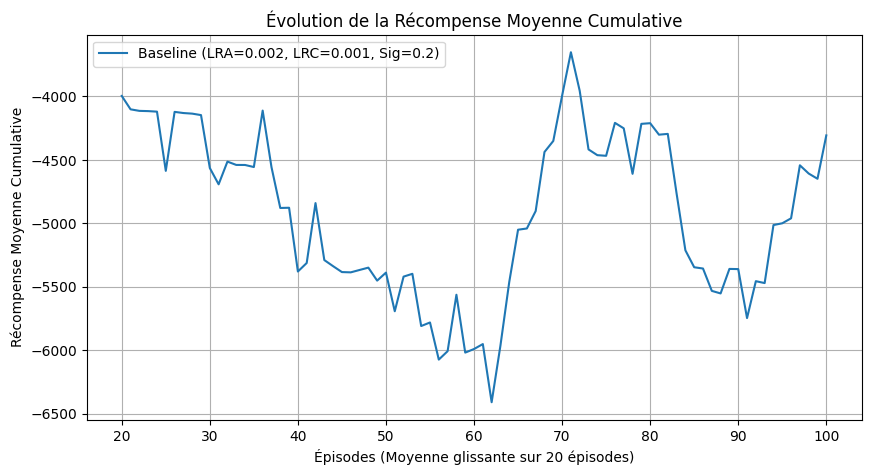

In [11]:
# Affichage de la moyenne des rewards cumulés$
import numpy as np
import matplotlib.pyplot as plt
# 2.7 Diagnostique (Affichage de la moyenne des rewards cumulés)

def plot_smoothed_rewards(rewards, window=20, label="Reward", title="Évolution de la Récompense Moyenne Cumulative"):
    """Calcule et affiche la moyenne glissante des récompenses."""
    if len(rewards) == 0:
        print("Aucune récompense à afficher.")
        return
        
    smoothed_rewards = [np.mean(rewards[i:i + window]) for i in range(0, len(rewards) - window + 1)]
    episodes = range(window, len(rewards) + 1)
    
    plt.figure("Diagnostique DDPG", figsize=(10, 5))
    plt.plot(episodes, smoothed_rewards, label=label)
    plt.xlabel(f"Épisodes (Moyenne glissante sur {window} épisodes)")
    plt.ylabel("Récompense Moyenne Cumulative")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# Affichage des résultats de la baseline
plot_smoothed_rewards(REWARDS_BASELINE, window=20, label="Baseline (LRA=0.002, LRC=0.001, Sig=0.2)")


### Réglage des paramètres d'apprentissage

Essayer différents paramètres utilisés lors de l'apprentissage ainsi que différentes architecture de réseaux pour  nombres de points d'évaluation et les fonctions d'acquisition PI et LCB pour tenter d'améliorer le paramétrage de l'algorithme. 


--- Réglage des paramètres d'apprentissage (Exemples) ---

--- Début de l'entrainement DDPG (M=100) ---
État dim: 4, Action dim: 2
Épisode 1/100: Récompense cumulée = -2842.42, Pas = 100
Épisode 2/100: Récompense cumulée = 44.80, Pas = 100
Épisode 3/100: Récompense cumulée = -9332.27, Pas = 100
Épisode 4/100: Récompense cumulée = 204.01, Pas = 100
Épisode 5/100: Récompense cumulée = 91.80, Pas = 100
Épisode 6/100: Récompense cumulée = -9120.35, Pas = 100
Épisode 7/100: Récompense cumulée = 59.16, Pas = 100
Épisode 8/100: Récompense cumulée = -8948.57, Pas = 100
Épisode 9/100: Récompense cumulée = -8739.98, Pas = 100
Épisode 10/100: Récompense cumulée = -9482.65, Pas = 100
Épisode 11/100: Récompense cumulée = -7456.31, Pas = 100
Épisode 12/100: Récompense cumulée = -9163.85, Pas = 100
Épisode 13/100: Récompense cumulée = -8739.89, Pas = 100
Épisode 14/100: Récompense cumulée = -8612.60, Pas = 100
Épisode 15/100: Récompense cumulée = 18.79, Pas = 100
Épisode 16/100: Récompense cumulée =

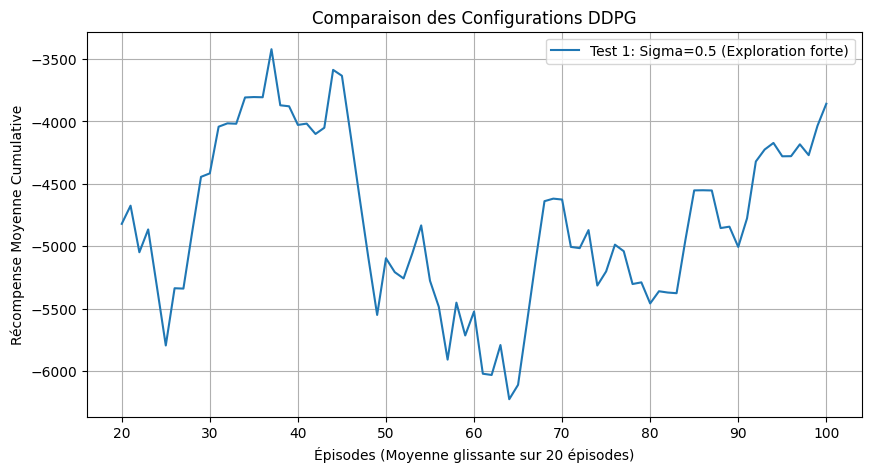


--- Début de l'entrainement DDPG (M=100) ---
État dim: 4, Action dim: 2
Épisode 1/100: Récompense cumulée = -4057.47, Pas = 100
Épisode 2/100: Récompense cumulée = -9339.82, Pas = 100
Épisode 3/100: Récompense cumulée = 250.07, Pas = 100
Épisode 4/100: Récompense cumulée = -9304.02, Pas = 100
Épisode 5/100: Récompense cumulée = -9172.52, Pas = 100
Épisode 6/100: Récompense cumulée = -2132.39, Pas = 100
Épisode 7/100: Récompense cumulée = 226.26, Pas = 100
Épisode 8/100: Récompense cumulée = -9224.09, Pas = 100
Épisode 9/100: Récompense cumulée = 73.20, Pas = 100
Épisode 10/100: Récompense cumulée = -1261.85, Pas = 100
Épisode 11/100: Récompense cumulée = -82.58, Pas = 100
Épisode 12/100: Récompense cumulée = -9341.33, Pas = 100
Épisode 13/100: Récompense cumulée = 231.92, Pas = 100
Épisode 14/100: Récompense cumulée = 46.82, Pas = 100
Épisode 15/100: Récompense cumulée = 317.77, Pas = 100
Épisode 16/100: Récompense cumulée = 52.36, Pas = 100
Épisode 17/100: Récompense cumulée = -8945.

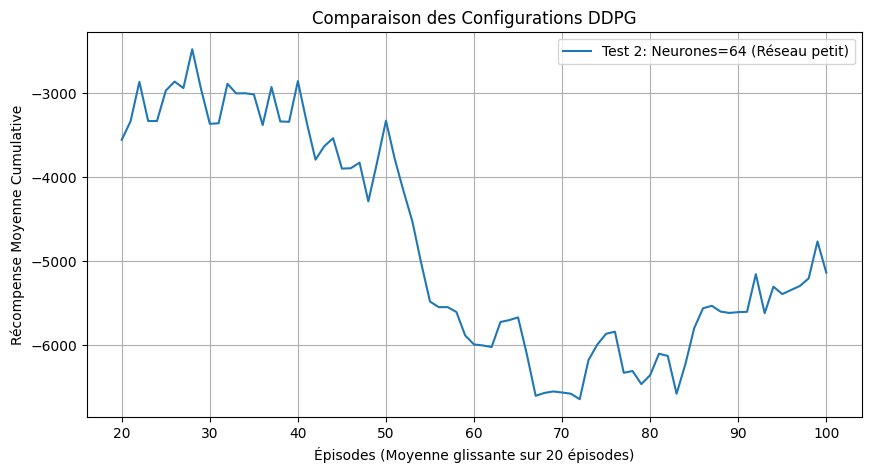


--- Début de l'entrainement DDPG (M=100) ---
État dim: 4, Action dim: 2
Épisode 1/100: Récompense cumulée = -9640.15, Pas = 100
Épisode 2/100: Récompense cumulée = -2142.93, Pas = 100
Épisode 3/100: Récompense cumulée = -9543.76, Pas = 100
Épisode 4/100: Récompense cumulée = -6506.54, Pas = 100
Épisode 5/100: Récompense cumulée = 83.17, Pas = 100
Épisode 6/100: Récompense cumulée = -9081.17, Pas = 100
Épisode 7/100: Récompense cumulée = -9477.28, Pas = 100
Épisode 8/100: Récompense cumulée = -8520.07, Pas = 100
Épisode 9/100: Récompense cumulée = 101.70, Pas = 100
Épisode 10/100: Récompense cumulée = -8631.44, Pas = 100
Épisode 11/100: Récompense cumulée = 49.39, Pas = 100
Épisode 12/100: Récompense cumulée = -8409.33, Pas = 100
Épisode 13/100: Récompense cumulée = -9203.41, Pas = 100
Épisode 14/100: Récompense cumulée = -9120.39, Pas = 100
Épisode 15/100: Récompense cumulée = -9279.48, Pas = 100
Épisode 16/100: Récompense cumulée = 112.87, Pas = 100
Épisode 17/100: Récompense cumulée

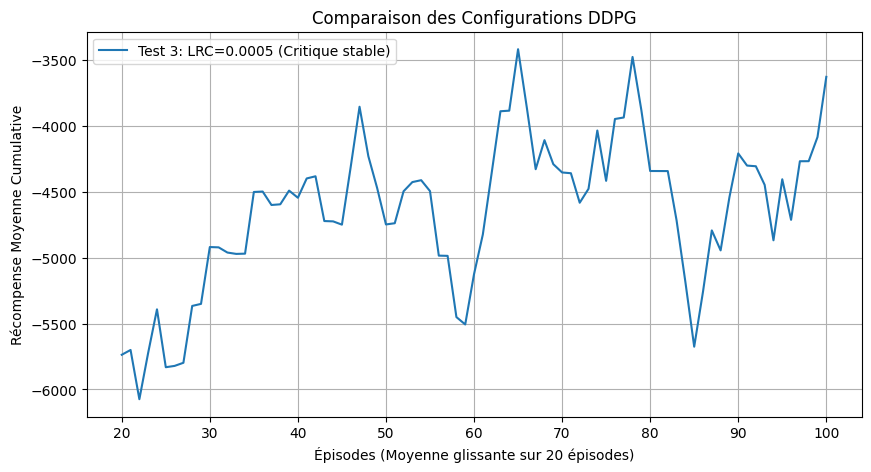


Analyse des résultats: Le choix des hyperparamètres (learning rates, bruit, architecture) a un impact critique sur la convergence de DDPG. La configuration la plus efficiente est celle dont la courbe de récompense moyenne monte le plus rapidement et atteint le plateau le plus élevé.


In [12]:
# Tests et évaluation avec différentes configurations

# 2.8 Réglage des paramètres d'apprentissage
# Tests et évaluation avec différentes configurations

print("\n--- Réglage des paramètres d'apprentissage (Exemples) ---")

# Test 1: Augmentation de l'exploration (Sigma)
REWARDS_TEST1, _, _ = ddpg_train(
    env=env,
    buffer_size=1000,
    batch_size=100,
    M=100,
    gamma=0.99,
    tau=0.005,
    lra=0.002,
    lrc=0.001,
    sigma=0.5, # Plus d'exploration
    nu=0.0,
    neurons=256,
    render_env=False
)
plot_smoothed_rewards(REWARDS_TEST1, window=20, label="Test 1: Sigma=0.5 (Exploration forte)", title="Comparaison des Configurations DDPG")

# Test 2: Réseau plus petit (moins de neurones)
REWARDS_TEST2, _, _ = ddpg_train(
    env=env,
    buffer_size=1000,
    batch_size=100,
    M=100,
    gamma=0.99,
    tau=0.005,
    lra=0.002,
    lrc=0.001,
    sigma=0.2,
    nu=0.0,
    neurons=64, # Architecture réduite
    render_env=False
)
plot_smoothed_rewards(REWARDS_TEST2, window=20, label="Test 2: Neurones=64 (Réseau petit)", title="Comparaison des Configurations DDPG")

# Test 3: Taux d'apprentissage réduit pour le critique (plus de stabilité)
REWARDS_TEST3, _, _ = ddpg_train(
    env=env,
    buffer_size=1000,
    batch_size=100,
    M=100,
    gamma=0.99,
    tau=0.005,
    lra=0.002,
    lrc=0.0005, # LRC réduit
    sigma=0.2,
    nu=0.0,
    neurons=256,
    render_env=False
)
plot_smoothed_rewards(REWARDS_TEST3, window=20, label="Test 3: LRC=0.0005 (Critique stable)", title="Comparaison des Configurations DDPG")

# Afficher tous les tests sur un seul graphique (si les figures sont affichées séparemment par le backend)
# Pour une meilleure visualisation, assurez-vous que les résultats sont bien affichés dans le même graphique si possible.
# Dans un environnement notebook, la fonction plot_smoothed_rewards avec la même figure 'Diagnostique DDPG' s'en charge.

# Vous pouvez maintenant analyser les graphiques générés (si le backend QT ou inline est activé)
print("\nAnalyse des résultats: Le choix des hyperparamètres (learning rates, bruit, architecture) a un impact critique sur la convergence de DDPG. La configuration la plus efficiente est celle dont la courbe de récompense moyenne monte le plus rapidement et atteint le plateau le plus élevé.")


--- Running Baseline ---

--- Début de l'entrainement DDPG (M=30) ---
État dim: 4, Action dim: 2
Épisode 1/30: Récompense cumulée = -9198.20, Pas = 100
Épisode 2/30: Récompense cumulée = -9877.78, Pas = 100
Épisode 3/30: Récompense cumulée = 200.74, Pas = 100
Épisode 4/30: Récompense cumulée = -9980.74, Pas = 100
Épisode 5/30: Récompense cumulée = -8896.85, Pas = 100
Épisode 6/30: Récompense cumulée = 72.00, Pas = 100
Épisode 7/30: Récompense cumulée = -9211.26, Pas = 100
Épisode 8/30: Récompense cumulée = -8939.40, Pas = 100
Épisode 9/30: Récompense cumulée = -9046.14, Pas = 100
Épisode 10/30: Récompense cumulée = -8591.39, Pas = 100
Épisode 11/30: Récompense cumulée = -6874.64, Pas = 100
Épisode 12/30: Récompense cumulée = -8499.82, Pas = 100
Épisode 13/30: Récompense cumulée = -3418.66, Pas = 100
Épisode 14/30: Récompense cumulée = 62.20, Pas = 100
Épisode 15/30: Récompense cumulée = -9404.25, Pas = 100
Épisode 16/30: Récompense cumulée = -8120.13, Pas = 100
Épisode 17/30: Récompen

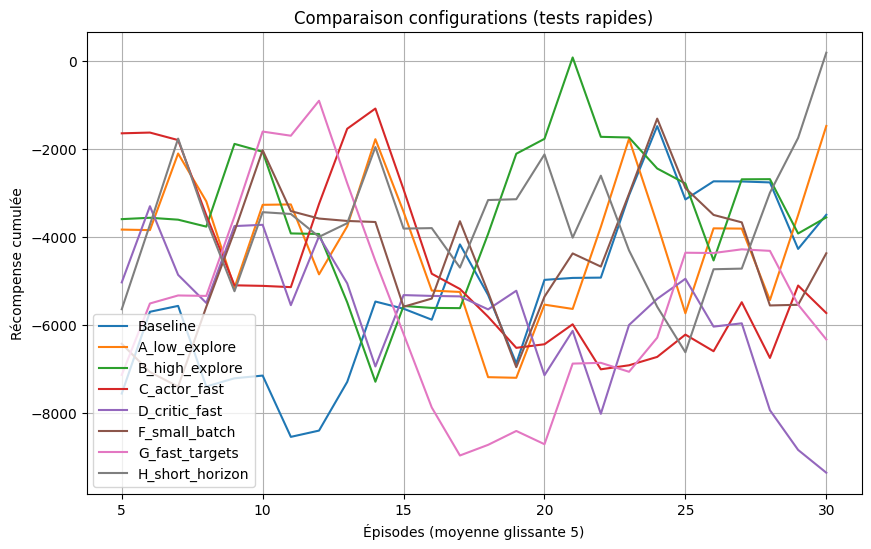

In [13]:
# Utilisez un nombre d'épisodes petit pour tests rapides (ex: M=30)
tests = [
    {"name":"Baseline", "sigma":0.2, "lra":0.002, "lrc":0.001, "neurons":256, "batch_size":100, "buffer_size":1000, "tau":0.005, "gamma":0.99},
    {"name":"A_low_explore", "sigma":0.05, "lra":0.002, "lrc":0.001, "neurons":256, "batch_size":100, "buffer_size":1000, "tau":0.005, "gamma":0.99},
    {"name":"B_high_explore", "sigma":0.8, "lra":0.002, "lrc":0.001, "neurons":256, "batch_size":100, "buffer_size":1000, "tau":0.005, "gamma":0.99},
    {"name":"C_actor_fast", "sigma":0.2, "lra":0.01,  "lrc":0.001, "neurons":256, "batch_size":100, "buffer_size":1000, "tau":0.005, "gamma":0.99},
    {"name":"D_critic_fast", "sigma":0.2, "lra":0.002, "lrc":0.01,  "neurons":256, "batch_size":100, "buffer_size":1000, "tau":0.005, "gamma":0.99},
    {"name":"F_small_batch", "sigma":0.2, "lra":0.002, "lrc":0.001, "neurons":256, "batch_size":32,  "buffer_size":2000, "tau":0.005, "gamma":0.99},
    {"name":"G_fast_targets", "sigma":0.2, "lra":0.002, "lrc":0.001, "neurons":256, "batch_size":100, "buffer_size":1000, "tau":0.02,  "gamma":0.99},
    {"name":"H_short_horizon", "sigma":0.2, "lra":0.002, "lrc":0.001, "neurons":256, "batch_size":512, "buffer_size":10000, "tau":0.005, "gamma":0.95},
]

results = {}
M_quick = 30  # épisode court pour tests rapides

for cfg in tests:
    print(f"\n--- Running {cfg['name']} ---")
    rew, actor, critic = ddpg_train(
        env=env,
        buffer_size=cfg["buffer_size"],
        batch_size=cfg["batch_size"],
        M=M_quick,
        gamma=cfg["gamma"],
        tau=cfg["tau"],
        lra=cfg["lra"],
        lrc=cfg["lrc"],
        sigma=cfg["sigma"],
        nu=0.0,
        neurons=cfg["neurons"],
        render_env=False
    )
    results[cfg["name"]] = rew

plt.figure(figsize=(10,6))
window = 5
for name, rew in results.items():
    if len(rew) >= window:
        sm = [np.mean(rew[i:i+window]) for i in range(len(rew)-window+1)]
        ep = range(window, len(rew)+1)
        plt.plot(ep, sm, label=name)
plt.xlabel(f"Épisodes (moyenne glissante {window})")
plt.ylabel("Récompense cumulée")
plt.legend()
plt.grid(True)
plt.title("Comparaison configurations (tests rapides)")
plt.show()